半开放建筑: x [-34052.97, 180882.88], y [-106.90, 144522.96]
实体建筑: x [-34107.94, 180874.27], y [-78.74, 144566.31]
道路: x [-22691.39, 170259.02], y [2033.22, 138916.04]
假山: x [-12764.09, 170971.87], y [41102.58, 122395.86]
水体: x [2729.99, 169897.47], y [5061.97, 135004.27]
植物: x [-31899.02, 176777.20], y [2435.43, 141755.08]


C:\Users\xiaosuange\AppData\Local\Temp\ipykernel_3404\3835447342.py:111: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig("yuanlin_elements_map_with_plants.png", dpi=300, bbox_inches='tight')
H:\anaconda\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


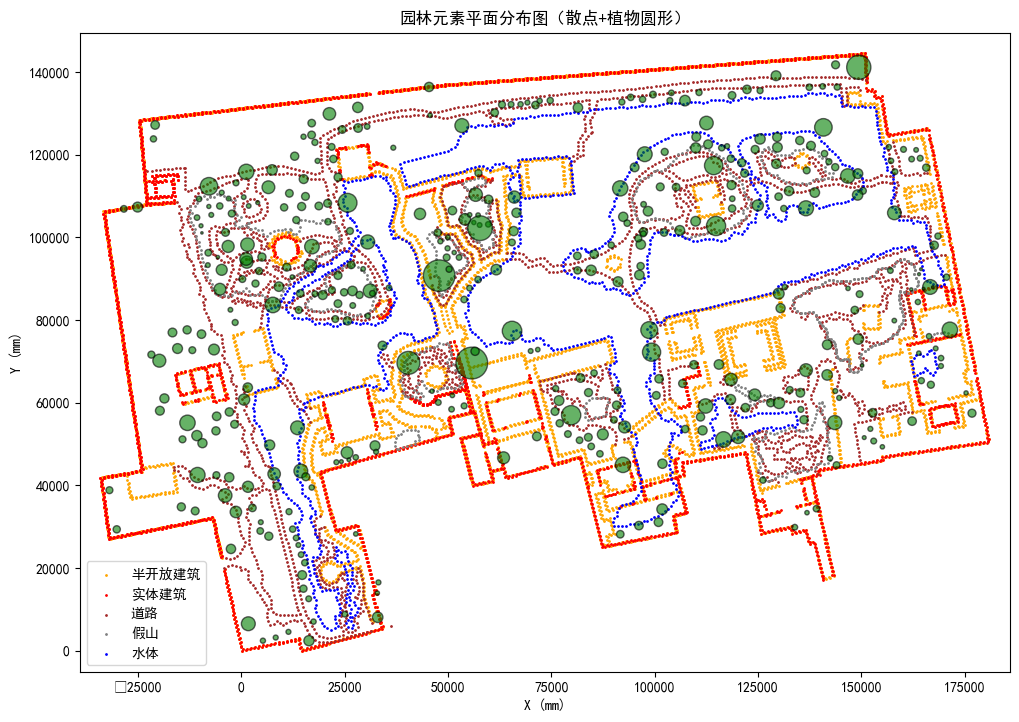

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

plt.rcParams["font.sans-serif"] = ["SimHei"]

# -----------------------
# 解析坐标字符串 {x, y, z} -> [x, y]
# -----------------------
def parse_point(s):
    s = re.sub(r"[{}]", "", str(s))
    parts = s.split(",")
    if len(parts) < 2:
        return [np.nan, np.nan]
    try:
        return [float(parts[0]), float(parts[1])]
    except:
        return [np.nan, np.nan]

# -----------------------
# Excel 文件路径和 sheet 名
# -----------------------
file = "data.xlsx"
sheet_names = ["半开放建筑", "实体建筑", "道路", "假山", "水体", "植物"]

# -----------------------
# 读取数据并转换为坐标
# -----------------------
data_dict = {}
for sheet in sheet_names:
    df = pd.read_excel(file, sheet_name=sheet)
    if sheet == "植物":
        # 植物中心坐标在第一列
        coords = df.iloc[:, 0].dropna().apply(parse_point).tolist()
    else:
        # 其他元素取第二列（不区分线段）
        coords = df.iloc[:, 1].dropna().apply(parse_point).tolist()
    coords = np.array(coords)
    coords = coords[~np.isnan(coords).any(axis=1)]
    data_dict[sheet] = coords

# -----------------------
# 绘图颜色字典
# -----------------------
color_dict = {
    "半开放建筑": "orange",
    "实体建筑": "red",
    "道路": "brown",
    "假山": "gray",
    "水体": "blue",
    "植物": "green"
}

plt.figure(figsize=(12, 12))
ax = plt.gca()

# -----------------------
# 计算所有元素坐标范围，排除 NaN
# -----------------------
all_coords = np.vstack([coords for coords in data_dict.values() if coords.shape[0] > 0])
x_min, x_max = np.min(all_coords[:, 0]), np.max(all_coords[:, 0])
y_min, y_max = np.min(all_coords[:, 1]), np.max(all_coords[:, 1])

# -----------------------
# 绘制每个元素
# -----------------------
for sheet, coords in data_dict.items():
    if coords.shape[0] == 0:
        continue
    x, y = coords[:, 0], coords[:, 1]

    # 打印每个元素的范围
    print(f"{sheet}: x [{x.min():.2f}, {x.max():.2f}], y [{y.min():.2f}, {y.max():.2f}]")

    if sheet == "植物":
        df = pd.read_excel(file, sheet_name=sheet)
        centers = df.iloc[:, 0].dropna().apply(parse_point).tolist()
        diameters = df.iloc[:, 1].dropna().tolist()
        for (cx, cy), d in zip(centers, diameters):
            radius = d / 2  # 冠径/2 = 半径
            circle = plt.Circle((cx, cy), radius, facecolor=color_dict[sheet], edgecolor='black', alpha=0.6)
            ax.add_patch(circle)
    else:
        ax.scatter(x, y, color=color_dict[sheet], s=1, label=sheet)

# -----------------------
# 设置坐标范围
# -----------------------
ax.set_xlim(x_min - 5000, x_max + 5000)
ax.set_ylim(y_min - 5000, y_max + 5000)
ax.set_aspect('equal', adjustable='box')

# -----------------------
# 去重图例
# -----------------------
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# -----------------------
# 坐标轴与标题
# -----------------------
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("园林元素平面分布图（散点+植物圆形）")

# -----------------------
# 保存并显示
# -----------------------
plt.savefig("yuanlin_elements_map_with_plants.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1200x1200 with 0 Axes>

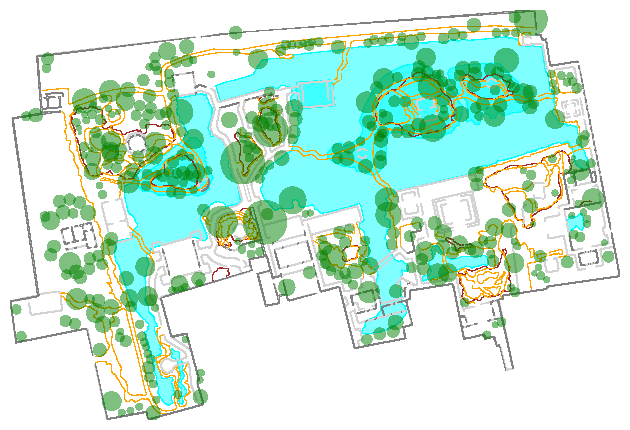

<Figure size 640x480 with 0 Axes>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib as mpl

# 全局关闭抗锯齿
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 0

# -----------------------
# 解析 {x,y,z} -> [x,y]
# -----------------------
def parse_point(s):
    s = re.sub(r"[{}]", "", str(s))
    parts = s.split(",")
    if len(parts) < 2:
        return [np.nan, np.nan]
    try:
        return [float(parts[0]), float(parts[1])]
    except:
        return [np.nan, np.nan]

# -----------------------
# 正则解析线段数据
# -----------------------
segment_re = re.compile(r"^{(\d+);(\d+)}$")
point_re = re.compile(r"^\s*\d+\.\s*{([\d\.\-]+),\s*([\d\.\-]+),\s*[\d\.\-]+}")

def parse_segments(series):
    """解析非植物 sheet 的线段列"""
    segments = {}
    current_seg = None

    for val in series.dropna():
        s = str(val).strip()

        # 线段起始标记 {0;a}
        m_seg = segment_re.match(s)
        if m_seg:
            current_seg = int(m_seg.group(2))
            segments[current_seg] = []
            continue

        # 点数据 b. {x,y,z}
        m_pt = point_re.match(s)
        if m_pt and current_seg is not None:
            x, y = float(m_pt.group(1)), float(m_pt.group(2))
            segments[current_seg].append((x, y))

    return segments

# -----------------------
# 文件和 sheet
# -----------------------
file = r"data.xlsx"
sheet_names = ["半开放建筑", "实体建筑", "道路", "假山", "水体", "植物"]

# -----------------------
# 绘图颜色
# -----------------------
color_dict = {
    "半开放建筑": "lightgray",
    "实体建筑": "gray",
    "道路": "orange",
    "假山": "brown",
    "水体": "aqua",
    "植物": "green"
}
order_dict = {
    "半开放建筑": 9,
    "实体建筑": 10,
    "道路": 3,
    "假山": 2,
    "水体": 0,
    "植物": 15
}

# -----------------------
# 解析数据
# -----------------------
all_points = []
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# 收集所有元素
draw_list = []
for sheet in sheet_names:
    df = pd.read_excel(file, sheet_name=sheet)

    if sheet == "植物":
        # 第一列中心点，第二列冠径
        centers = df.iloc[:, 0].dropna().apply(parse_point).tolist()
        diameters = df.iloc[:, 1].dropna().tolist()

        for (cx, cy), d in zip(centers, diameters):
            radius = d
            draw_list.append(dict(type="circle", value={"center": (cx, cy), "radius": radius}, type_str=sheet))
            all_points.append((cx, cy))

    else:
        # 非植物 → 用正则解析线段
        segments = parse_segments(df.iloc[:, 0])

        for seg_id, pts in segments.items():
            pts = np.array(pts)
            if len(pts) > 1:
                draw_list.append(dict(type="line", value=(pts[:, 0], pts[:, 1]), type_str=sheet))
                all_points.extend(pts.tolist())

            # 如果线段是闭合的，则记为多边形
            if len(pts) > 2:
                avg_distance = np.mean(np.linalg.norm(pts[:-1] - pts[1:], axis=1))
                if np.linalg.norm(pts[0] - pts[-1]) < avg_distance * 2:
                    draw_list.append(dict(type="polygon", value=pts, type_str=sheet))

# 绘制所有元素
for item in draw_list:
    if item["type"] == "circle":
        circle = plt.Circle(item["value"]["center"], item["value"]["radius"], facecolor=color_dict[item["type_str"]], alpha=0.5, zorder=order_dict[item["type_str"]], antialiased=False)
        ax.add_patch(circle)
    elif item["type"] == "line":
        ax.plot(item["value"][0], item["value"][1], color=color_dict[item["type_str"]], linewidth=0.1, zorder=order_dict[item["type_str"]], antialiased=False)
    elif item["type"] == "polygon" and item["type_str"] == "水体":
        ax.fill(item["value"][:, 0], item["value"][:, 1], color=color_dict[item["type_str"]], alpha=0.5, zorder=order_dict[item["type_str"]], antialiased=False, edgecolor='none')

# -----------------------
# 设置范围和美化，取消抗锯齿
# -----------------------
all_points = np.array(all_points)
x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])

# plt.figure(figsize=((x_max - x_min) / 10000, (y_max - y_min) / 10000))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.savefig("yuanlin_elements_map_clean.png", dpi=100, bbox_inches='tight', pad_inches=0)


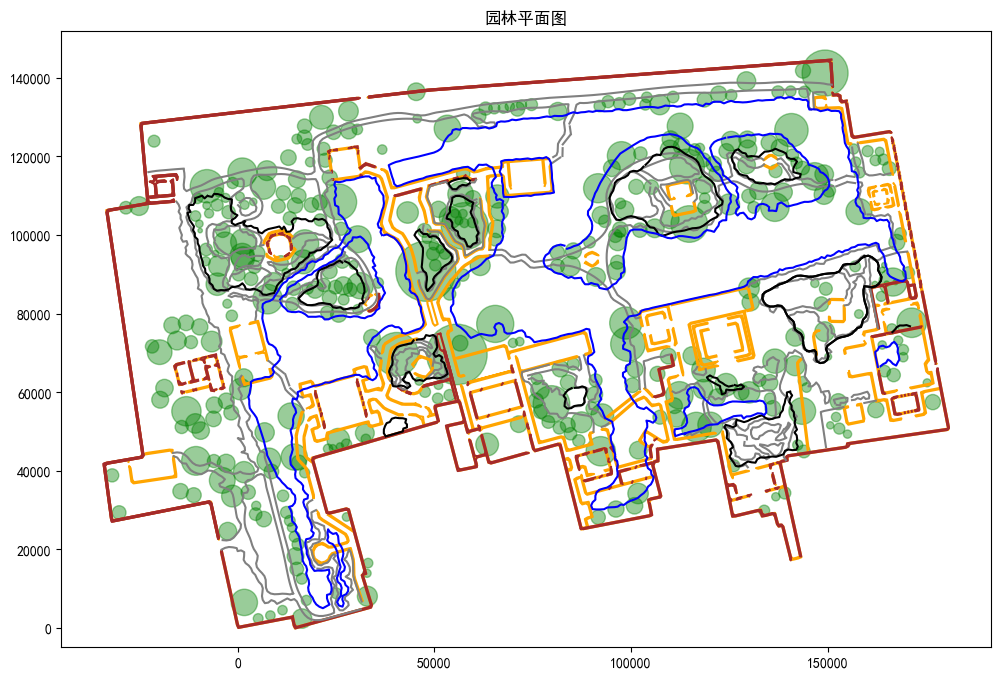

In [1]:
# 文件名：01_visualize_garden.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import ast

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# ========== 工具函数 ==========
def parse_point(s):
    """解析形如 {x,y,0} 的字符串为 (x, y)"""
    if isinstance(s, str):
        s = s.strip().replace("{", "").replace("}", "")
        vals = [float(v) for v in s.split(",")]
        return vals[0], vals[1]
    return None

def parse_group_data(df):
    """将类似 {0;i}, j.{x,y,0} 的分组数据转为列表"""
    groups = {}
    current_group = None
    for item in df.iloc[:,0]:
        if isinstance(item, str) and item.strip().startswith("{0;"):
            current_group = item
            groups[current_group] = []
        else:
            if isinstance(item, str) and "." in item:
                _, point_str = item.split(".", 1)
                groups[current_group].append(parse_point(point_str))
    return groups

# ========== 数据读取 ==========
file = "data.xlsx"
sheets = ["半开放建筑", "实体建筑", "道路", "假山", "水体", "植物"]

# 植物
df_plants = pd.read_excel(file, sheet_name="植物")
plants = [(parse_point(df_plants.iloc[i,0]), df_plants.iloc[i,1]) for i in range(1, len(df_plants))]

# 其它要素
elements = {}
for sheet in sheets[:-1]:  # 前5类
    df = pd.read_excel(file, sheet_name=sheet)
    groups = parse_group_data(df)
    elements[sheet] = groups

# ========== 可视化 ==========
plt.figure(figsize=(12, 8))

# 绘制植物
for (x,y), r in plants:
    circle = plt.Circle((x,y), r, color="green", alpha=0.4)
    plt.gca().add_patch(circle)

# 绘制其它要素
colors = {
    "半开放建筑": "orange",
    "实体建筑": "brown",
    "道路": "gray",
    "假山": "black",
    "水体": "blue"
}
for name, groups in elements.items():
    for _, pts in groups.items():
        xs, ys = zip(*pts)
        plt.plot(xs, ys, color=colors[name], label=name)

plt.title("园林平面图")
plt.axis("equal")
# plt.legend()
plt.savefig("demo.png")
plt.show()
# save



读取数据...
未发现显式场地边界，使用 alpha-shape 推断
alpha_use=0.000170819, bbox_diag=292708.1
栅格化场地...
计算骨架...
像素骨架 -> 矢量链...
像素链数量: 1269
可视化结果...


H:\anaconda\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


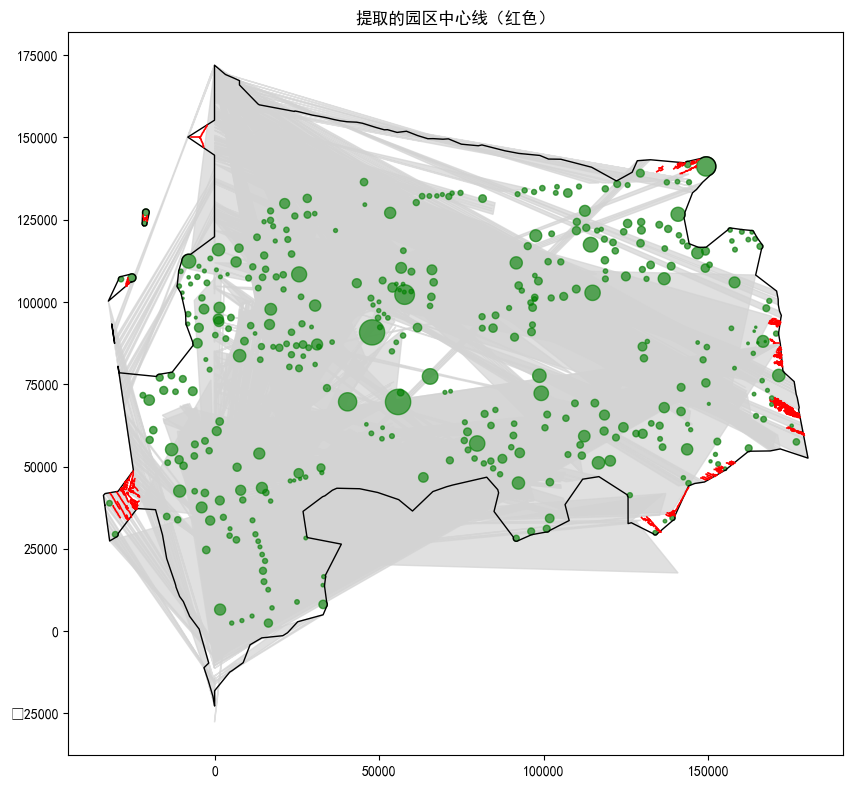

已保存中心线到 centerlines.geojson


In [7]:
"""
extract_centerlines.py

功能：从 data.xlsx 中的边界数据（除植物外均为障碍边界）提取园区可通行区域的中心线并可视化。
要点：
- 不使用 eval，使用正则解析坐标字符串；
- 自动识别/推断场地边界（优先使用名为“边界/场地/场地边界”的 sheet），否则用 alpha-shape 回退到凸包；
- 使用栅格化 + skeletonize（scikit-image）提取骨架，比 Voronoi 更稳定、分支可控；
- 包含短分支去噪、像素链转矢量线、回投到原坐标系并做简化；
- 可视化结果并保存 GeoJSON。

依赖：
pip install numpy pandas shapely matplotlib scipy pillow scikit-image openpyxl

将 data.xlsx 放在同一目录，然后运行：
python extract_centerlines.py

"""

import re
import math
import json
from collections import deque

import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point, MultiPolygon, LineString, MultiLineString
from shapely.ops import unary_union, polygonize
import shapely

from PIL import Image, ImageDraw
try:
    from skimage.morphology import skeletonize
    from skimage.measure import label
except Exception:
    skeletonize = None
    label = None

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# ---------------------- 参数（可调） ----------------------
FILE_PATH = 'data.xlsx'
SHEET_NAMES = ['半开放建筑','实体建筑','道路','假山','水体','植物']
ALPHA = None  # 自动选择 alpha（可人工设定）
TARGET_PX = 1200
MIN_BRANCH_PX = 20
SIMPLIFY_TOL = 5.0
OUT_CENTERLINES = 'centerlines.geojson'

# ---------------------- 解析（无需 eval） ----------------------
num_re = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")

def is_group_marker(s: str) -> bool:
    if s is None:
        return False
    s = str(s).strip()
    return bool(re.match(r'^\{?\s*0\s*[,;]', s)) or s.strip().lower().startswith('0;')


def parse_coord(s: str):
    if s is None:
        return None
    s = str(s).strip()
    if is_group_marker(s):
        return None
    nums = num_re.findall(s)
    if len(nums) >= 2:
        try:
            return float(nums[0]), float(nums[1])
        except Exception:
            return None
    return None


def flatten_sheet_cells(df: pd.DataFrame):
    tokens = []
    for row in df.itertuples(index=False):
        for cell in row:
            if pd.isna(cell):
                continue
            s = str(cell).strip()
            if s == '':
                continue
            tokens.append(s)
    return tokens


def read_groups_from_tokens(tokens):
    groups = []
    cur = []
    for tok in tokens:
        if is_group_marker(tok):
            if cur:
                groups.append(cur)
                cur = []
            continue
        pt = parse_coord(tok)
        if pt:
            cur.append(pt)
    if cur:
        groups.append(cur)
    return groups

# ---------------------- 读取 Excel（容错） ----------------------

def load_data(file_path: str):
    xl = pd.read_excel(file_path, sheet_name=None, header=None, engine='openpyxl')
    obstacles = []
    plants = []
    site_boundary_candidates = []

    for name, df in xl.items():
        name = str(name).strip()
        if name == '植物':
            for r in range(len(df)):
                c0 = df.iloc[r, 0] if 0 in df.columns else None
                c1 = df.iloc[r, 1] if 1 in df.columns else None
                if pd.isna(c0):
                    continue
                center = parse_coord(str(c0))
                if center is None:
                    continue
                try:
                    diam = float(c1) if c1 is not None and not pd.isna(c1) else 0.0
                except Exception:
                    diam = 0.0
                radius = diam / 2.0
                circ = Point(center).buffer(radius, resolution=32)
                plants.append({'type':'植物','geom':circ})
                obstacles.append({'type':'plant','geom':circ})
        elif name in ['边界','场地','场地边界','boundary','site']:
            toks = flatten_sheet_cells(df)
            groups = read_groups_from_tokens(toks)
            for g in groups:
                if len(g) >= 3:
                    p = Polygon(g)
                    if not p.is_valid:
                        p = p.buffer(0)
                    site_boundary_candidates.append(p)
        else:
            toks = flatten_sheet_cells(df)
            groups = read_groups_from_tokens(toks)
            for g in groups:
                if len(g) >= 3:
                    p = Polygon(g)
                    if not p.is_valid:
                        p = p.buffer(0)
                    obstacles.append({'type': name, 'geom': p})
    return obstacles, plants, site_boundary_candidates

# ---------------------- alpha-shape（凹包） ----------------------

def alpha_shape(points, alpha):
    if len(points) < 4:
        return MultiPolygon([Point(tuple(p)).buffer(1.0) for p in points]).convex_hull
    try:
        tri = Delaunay(points)
    except Exception:
        return MultiPolygon([Point(tuple(p)).buffer(1.0) for p in points]).convex_hull
    edges = set()
    for ia, ib, ic in tri.simplices:
        pa = points[ia]; pb = points[ib]; pc = points[ic]
        a = np.linalg.norm(pb-pc); b = np.linalg.norm(pa-pc); c = np.linalg.norm(pa-pb)
        s = (a+b+c)/2.0
        area = max(s*(s-a)*(s-b)*(s-c), 0.0)
        if area <= 0:
            continue
        area = math.sqrt(area)
        circum_r = a*b*c/(4.0*area)
        if alpha is None:
            alpha_use = 1.0 / max(1.0, np.ptp(points[:,0]) + np.ptp(points[:,1]))
        else:
            alpha_use = alpha
        if circum_r < (1.0/alpha_use if alpha_use > 0 else 1e9):
            edges.add(tuple(sorted((ia, ib))))
            edges.add(tuple(sorted((ib, ic))))
            edges.add(tuple(sorted((ia, ic))))
    if not edges:
        return MultiPolygon([Point(tuple(p)).buffer(1.0) for p in points]).convex_hull
    mls = MultiLineString([(tuple(points[i]), tuple(points[j])) for i,j in edges])
    try:
        polys = list(polygonize(mls))
        if not polys:
            return MultiPolygon([Point(tuple(p)).buffer(1.0) for p in points]).convex_hull
        return unary_union(polys)
    except Exception:
        return MultiPolygon([Point(tuple(p)).buffer(1.0) for p in points]).convex_hull

# ---------------------- 栅格化与像素<->世界 坐标转换 ----------------------

def world_to_pixel(x, y, minx, miny, maxy, scale):
    px = int(round((x - minx) * scale))
    py = int(round((maxy - y) * scale))
    return px, py


def pixel_to_world(px, py, minx, miny, maxy, scale):
    x = minx + (px + 0.5) / scale
    y = maxy - (py + 0.5) / scale
    return (x, y)


def rasterize_area(site_boundary, obstacles_geoms, target_px=TARGET_PX):
    minx, miny, maxx, maxy = site_boundary.bounds
    width = maxx - minx
    height = maxy - miny
    if width <= 0 or height <= 0:
        raise RuntimeError('场地边界无效')
    scale = target_px / max(width, height)
    W = int(math.ceil(width * scale)) + 3
    H = int(math.ceil(height * scale)) + 3
    img = Image.new('L', (W, H), 0)
    draw = ImageDraw.Draw(img)
    def poly_to_px_coords(poly: Polygon):
        return [world_to_pixel(x, y, minx, miny, maxy, scale) for x, y in poly.exterior.coords]
    try:
        draw.polygon(poly_to_px_coords(site_boundary), fill=1)
    except Exception:
        if hasattr(site_boundary, 'geoms'):
            for p in site_boundary.geoms:
                draw.polygon(poly_to_px_coords(p), fill=1)
    for g in obstacles_geoms:
        if g.is_empty:
            continue
        if isinstance(g, (Polygon, MultiPolygon)):
            polys = [g] if isinstance(g, Polygon) else g.geoms
            for p in polys:
                try:
                    draw.polygon(poly_to_px_coords(p), fill=0)
                except Exception:
                    pass
        else:
            try:
                poly = g.buffer(1.0)
                draw.polygon(poly_to_px_coords(poly), fill=0)
            except Exception:
                pass
    arr = np.array(img, dtype=np.uint8)
    free_mask = arr == 1
    return free_mask, (minx, miny, maxx, maxy, scale)

# ---------------------- 像素骨架到像素链（去噪） ----------------------

def skeleton_to_lines(skel: np.ndarray, min_branch_px=MIN_BRANCH_PX):
    if label is None:
        raise RuntimeError('缺少 scikit-image 的 label 功能，请安装 scikit-image')
    lab = label(skel, connectivity=2)
    counts = np.bincount(lab.ravel())
    keep = np.zeros_like(lab, dtype=bool)
    for lbl, cnt in enumerate(counts):
        if lbl == 0:
            continue
        if cnt >= min_branch_px:
            keep |= (lab == lbl)
    skel_clean = keep
    pts = np.argwhere(skel_clean)
    if pts.size == 0:
        return []
    idx_map = { (int(r), int(c)): i for i,(r,c) in enumerate(pts) }
    neighbors = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    deg = {}
    nbrs = {}
    for (r,c) in pts:
        r=int(r); c=int(c)
        nlist = []
        for dr,dc in neighbors:
            rr = r+dr; cc = c+dc
            if (rr,cc) in idx_map:
                nlist.append((rr,cc))
        deg[(r,c)] = len(nlist)
        nbrs[(r,c)] = nlist
    visited = set()
    lines = []
    endpoints = [p for p,d in deg.items() if d != 2]
    for ep in endpoints:
        if ep in visited:
            continue
        for nb in nbrs[ep]:
            path = [ep, nb]
            visited.add(ep)
            visited.add(nb)
            cur = nb
            prev = ep
            while deg[cur] == 2:
                nbs = nbrs[cur]
                nxt = nbs[0] if nbs[0] != prev else (nbs[1] if len(nbs)>1 else None)
                if nxt is None or nxt in visited:
                    break
                path.append(nxt)
                visited.add(nxt)
                prev, cur = cur, nxt
            lines.append(path)
    remaining = [p for p in deg.keys() if p not in visited]
    for p in remaining:
        if p in visited:
            continue
        path = [p]
        visited.add(p)
        cur = p
        prev = None
        while True:
            nbs = nbrs[cur]
            nxt = None
            for nb in nbs:
                if nb != prev:
                    nxt = nb; break
            if nxt is None or nxt in visited:
                break
            path.append(nxt)
            visited.add(nxt)
            prev, cur = cur, nxt
        lines.append(path)
    return lines

# ---------------------- 主流程 ----------------------

def main():
    print('读取数据...')
    obstacles, plants, site_boundary_candidates = load_data(FILE_PATH)
    obstacle_geoms = [o['geom'] for o in obstacles]
    plant_geoms = [p['geom'] for p in plants]
    if site_boundary_candidates:
        print('使用 Excel 中的场地边界')
        site_boundary = unary_union(site_boundary_candidates)
    else:
        print('未发现显式场地边界，使用 alpha-shape 推断')
        sample_pts = []
        for g in obstacle_geoms:
            try:
                sample_pts.extend(list(g.exterior.coords))
            except Exception:
                pass
        for g in plant_geoms:
            try:
                sample_pts.extend(list(g.exterior.coords)[::8])
            except Exception:
                pass
        if not sample_pts:
            raise RuntimeError('无法推断场地边界：请在 Excel 中添加边界 sheet 或检查数据')
        pts = np.array(sample_pts)
        bbox_diag = math.hypot(np.ptp(pts[:,0]), np.ptp(pts[:,1]))
        if ALPHA is None:
            alpha_use = 1.0 / max(1.0, bbox_diag / 50.0)
        else:
            alpha_use = ALPHA
        print(f'alpha_use={alpha_use:.6g}, bbox_diag={bbox_diag:.1f}')
        try:
            site_boundary = alpha_shape(pts, alpha_use)
        except Exception:
            site_boundary = shapely.geometry.MultiPoint(pts).convex_hull
    obstacles_union = unary_union(obstacle_geoms + plant_geoms) if obstacle_geoms or plant_geoms else None
    free_area = site_boundary.difference(obstacles_union) if obstacles_union is not None else site_boundary
    if free_area.is_empty:
        raise RuntimeError('计算到空的可通行区域，请检查数据/场地边界与障碍')
    print('栅格化场地...')
    free_mask, (minx, miny, maxx, maxy, scale) = rasterize_area(site_boundary, obstacle_geoms + plant_geoms, target_px=TARGET_PX)
    if skeletonize is None:
        raise RuntimeError('缺少 scikit-image，请通过 pip install scikit-image 安装')
    print('计算骨架...')
    sk = skeletonize(free_mask)
    print('像素骨架 -> 矢量链...')
    lines_px = skeleton_to_lines(sk, min_branch_px=MIN_BRANCH_PX)
    print(f'像素链数量: {len(lines_px)}')
    lines_world = []
    for chain in lines_px:
        pts = [pixel_to_world(c, r, minx, miny, maxy, scale) for (r,c) in chain]
        if len(pts) < 2:
            continue
        ls = LineString(pts)
        if ls.length < 1e-6:
            continue
        ls2 = ls.simplify(SIMPLIFY_TOL)
        lines_world.append(ls2)
    centerlines = unary_union(lines_world) if lines_world else MultiLineString([])
    print('可视化结果...')
    fig, ax = plt.subplots(figsize=(10,10))
    if isinstance(site_boundary, (Polygon, MultiPolygon)):
        s_polys = [site_boundary] if isinstance(site_boundary, Polygon) else site_boundary.geoms
        for p in s_polys:
            x,y = p.exterior.xy
            ax.plot(x,y, color='black', lw=1)
    for g in obstacle_geoms:
        try:
            x,y = g.exterior.xy
            ax.fill(x,y, color='lightgray', alpha=0.7)
        except Exception:
            pass
    for p in plant_geoms:
        try:
            x,y = p.exterior.xy
            ax.fill(x,y, color='green', alpha=0.6)
        except Exception:
            pass
    def plot_lines(obj, col='red', lw=1.2):
        if obj.is_empty:
            return
        if isinstance(obj, LineString):
            xs, ys = obj.xy
            ax.plot(xs, ys, color=col, lw=lw)
        elif isinstance(obj, MultiLineString):
            for seg in obj.geoms:
                xs, ys = seg.xy
                ax.plot(xs, ys, color=col, lw=lw)
    plot_lines(centerlines, col='red', lw=1.2)
    ax.set_aspect('equal')
    ax.set_title('提取的园区中心线（红色）')
    plt.show()
    # 保存 GeoJSON
    try:
        geoms = [centerlines] if isinstance(centerlines, LineString) else (list(centerlines.geoms) if hasattr(centerlines, 'geoms') else [])
        features = []
        for g in geoms:
            features.append({'type':'Feature','properties':{},'geometry': shapely.geometry.mapping(g)})
        fc = {'type':'FeatureCollection','features':features}
        with open(OUT_CENTERLINES, 'w', encoding='utf-8') as f:
            json.dump(fc, f, ensure_ascii=False, indent=2)
        print(f'已保存中心线到 {OUT_CENTERLINES}')
    except Exception as e:
        print('保存 GeoJSON 失败：', e)

if __name__ == '__main__':
    main()


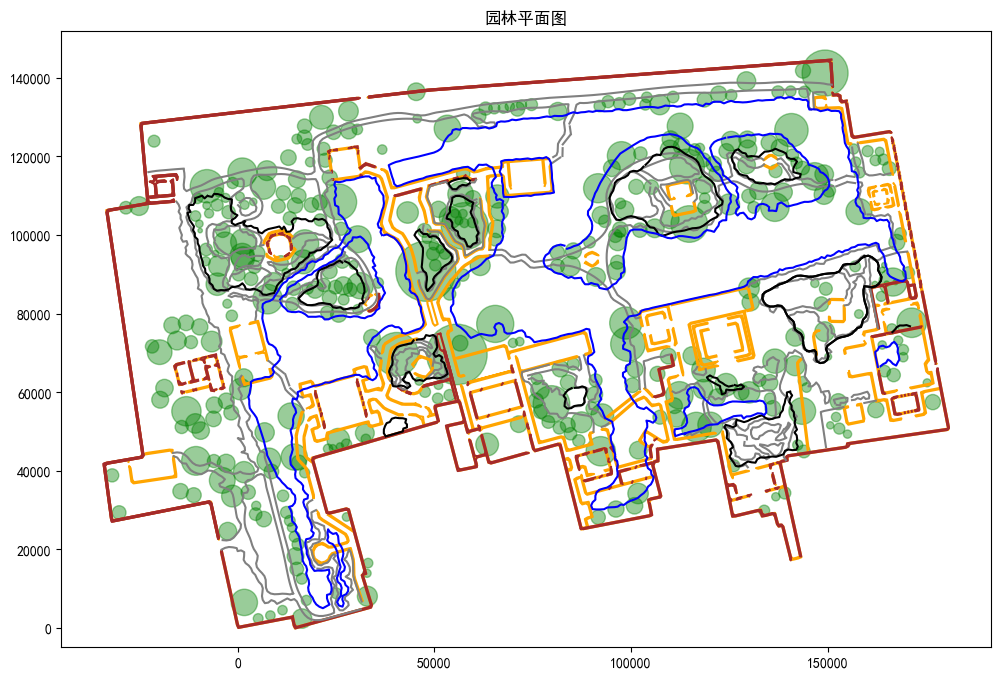

In [12]:
# 文件名：01_visualize_garden.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import ast

# ========== 工具函数 ==========
def parse_point(s):
    """解析形如 {x,y,0} 的字符串为 (x, y)"""
    if isinstance(s, str):
        s = s.strip().replace("{", "").replace("}", "")
        vals = [float(v) for v in s.split(",")]
        return vals[0], vals[1]
    return None

def parse_group_data(df):
    """将类似 {0;i}, j.{x,y,0} 的分组数据转为列表"""
    groups = {}
    current_group = None
    for item in df.iloc[:,0]:
        if isinstance(item, str) and item.strip().startswith("{0;"):
            current_group = item
            groups[current_group] = []
        else:
            if isinstance(item, str) and "." in item:
                _, point_str = item.split(".", 1)
                groups[current_group].append(parse_point(point_str))
    return groups

# ========== 数据读取 ==========
file = "data.xlsx"
sheets = ["半开放建筑", "实体建筑", "道路", "假山", "水体", "植物"]

# 植物
df_plants = pd.read_excel(file, sheet_name="植物")
plants = [(parse_point(df_plants.iloc[i,0]), df_plants.iloc[i,1]) for i in range(1, len(df_plants))]

# 其它要素
elements = {}
for sheet in sheets[:-1]:  # 前5类
    df = pd.read_excel(file, sheet_name=sheet)
    groups = parse_group_data(df)
    elements[sheet] = groups

# ========== 可视化 ==========
plt.figure(figsize=(12, 8))

# 绘制植物
for (x,y), r in plants:
    circle = plt.Circle((x,y), r, color="green", alpha=0.4)
    plt.gca().add_patch(circle)

# 绘制其它要素
colors = {
    "半开放建筑": "orange",
    "实体建筑": "brown",
    "道路": "gray",
    "假山": "black",
    "水体": "blue"
}
for name, groups in elements.items():
    for _, pts in groups.items():
        xs, ys = zip(*pts)
        plt.plot(xs, ys, color=colors[name], label=name)

plt.title("园林平面图")
plt.axis("equal")
plt.show()


Loading data...
Bounds: (-34107.939963, -78.743755, 999999.0, 147007.190633)
Building grid...
Grid size (h,w)= 736 5171
Rasterizing maps...
Plotting two maps...


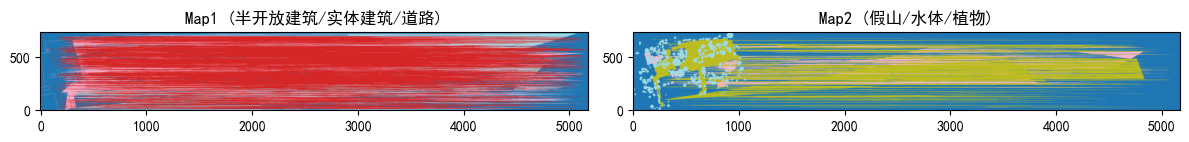

Auto selected START_WORLD from first road point: (-12419.319262, 107552.233763)
Start grid index: (538, 108)
Running BFS...
BFS finished: visited 60746 nodes, saved 277 paths, time 0.20s
Plotting final map with saved paths...


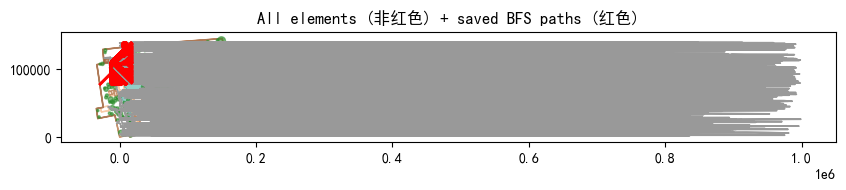

Done.


In [23]:
"""
Garden Path Planning — Rasterized Maps + BFS prototype

说明：
本脚本（适合放到 Jupyter notebook 或 .py）实现用户要求的步骤：
1) 构建两个平面图（map1：半开放建筑、实体建筑、道路；map2：假山、水体、植物），并显示；
2) 将两个地图按用户给定的缩放参数 rasterize 为二维矩阵；
   - map1: 道路标记为 1，半开放建筑/实体建筑由可变参数设定（默认不同值），无数据标记 0；
   - map2: 任何有数据的位置标记为可变参数（可按要素类型设置不同值），无数据为 0；
3) 定义搜索步长（以栅格单元数计）和搜索步数（广度优先最大层数），使用 BFS 在矩阵上进行受限搜索并保存路径；
4) 提供一个可扩展的接口，后续可以使用矩阵权值替换 BFS 为加权搜索（如 Dijkstra / A*）；
5) 在合成地图上绘制所有要素（非红色）并把保存的搜索路径以红色叠加，路径坐标缩放回原始世界坐标并取栅格中心作为点。

依赖：numpy, pandas, shapely, matplotlib, networkx (后续可用), openpyxl
pip install numpy pandas shapely matplotlib openpyxl

使用方法：
- 将 data.xlsx 放在同一目录；修改 FILE_PATH、CELL_SIZE_MM、入口坐标（START_WORLD）等参数；
- 在 Jupyter 中逐单元运行，或作为脚本运行（会绘图弹窗）。

"""

import math
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from collections import deque
import time

# ---------------------- 配置参数（请根据实际数据调整） ----------------------
FILE_PATH = 'data.xlsx'
SHEET_MAP1 = ['半开放建筑', '实体建筑', '道路']
SHEET_MAP2 = ['假山', '水体', '植物']

# 栅格化分辨率：每个像素代表多少毫米（mm）
CELL_SIZE_MM = 200.0   # -> 可调，值越小栅格越细、矩阵越大

# map1 值设定：道路固定1，建筑使用可变值
ROAD_VALUE = 1.0
SEMI_OPEN_VALUE = 2.0   # 半开放建筑在 map1 中的值
SOLID_VALUE = 3.0       # 实体建筑在 map1 中的值

# map2 值设定（可以对每种类型设置不同值）
MAP2_VALUES = {
    '假山': 4.0,
    '水体': 5.0,
    '植物': 6.0
}

# BFS 搜索参数
STEP_LENGTH_CELLS = 1   # 每一步移动多少个栅格（整数）
MAX_STEPS = 150         # 最大的 BFS 层数（深度）
NEIGHBOR_MODE = '8'     # '4' 或 '8' 邻域

# 保存路径上限
MAX_SAVED_PATHS = 200

# 起点（世界坐标，单位 mm）；如果为 None，脚本会尝试从道路要素中选取一个点
START_WORLD = None  # e.g. (x_mm, y_mm)

# 是否让建筑覆盖道路（若两者重叠）: True -> 建筑值覆盖道路，否则道路优先
BUILDING_OVERWRITES_ROAD = False

# ---------------------- 工具函数 ----------------------

def parse_point_str(s):
    """解析类似 '{x, y, 0}' 或 'x,y,0' 的字符串，返回 (x, y)
    对于无法解析的文本抛出异常。"""
    if isinstance(s, (list, tuple)) and len(s) >= 2:
        return float(s[0]), float(s[1])
    if not isinstance(s, str):
        raise ValueError('非字符串点')
    t = s.strip().replace('{', '').replace('}', '').replace('(', '').replace(')', '')
    parts = [p.strip() for p in t.split(',') if p.strip()!='']
    if len(parts) < 2:
        raise ValueError(f'无法解析点: {s}')
    return float(parts[0]), float(parts[1])


def read_sheet_groups(df: pd.DataFrame):
    """按照题意解析除植物外的 sheet：表格由分组（以含'{0;'或'0;'的行为新组）和后续的 j. {x,y,0} 行组成。
    返回每组为 list of (x,y)。"""
    groups = []
    current = []
    # 扫描每个单元格（按列优先）
    for col in df.columns:
        for v in df[col].dropna().astype(str):
            vs = v.strip()
            if vs.startswith('{0;') or vs.startswith('0;'):
                if current:
                    groups.append(current)
                current = []
            else:
                # 可能包含 "j. {x,y,0}" 或 "{x,y,0}"
                if '.' in vs:
                    try:
                        _, rest = vs.split('.', 1)
                        p = parse_point_str(rest)
                        current.append(p)
                    except Exception:
                        # 尝试直接解析整个字段
                        try:
                            p = parse_point_str(vs)
                            current.append(p)
                        except Exception:
                            continue
                else:
                    try:
                        p = parse_point_str(vs)
                        current.append(p)
                    except Exception:
                        continue
    if current:
        groups.append(current)
    return groups


def read_plants_sheet(df: pd.DataFrame):
    """读取植物表格: 第一列为中心 {x,y,0}，第二列为冠径/半径（题述含糊，默认第二列是半径）。返回列表[(x,y), r]
    自动跳过解析失败的行。"""
    plants = []
    for i, row in df.iterrows():
        try:
            center = parse_point_str(row.iloc[0])
            r = float(row.iloc[1]) if not pd.isna(row.iloc[1]) else 0.0
            plants.append((center, float(r)))
        except Exception:
            continue
    return plants


def load_data(file_path: str):
    """从 data.xlsx 加载并解析要素，返回 dict:
    {
       '半开放建筑': [Polygon,...], '实体建筑': [Polygon,...], '道路':[LineString,...],
       '假山': [Polygon], '水体':[Polygon], '植物': [(center, r), ...]
    }
    """
    xl = pd.read_excel(file_path, sheet_name=None, engine='openpyxl')
    out = {k: [] for k in SHEET_MAP1 + SHEET_MAP2}
    for name, df in xl.items():
        name = name.strip()
        if name in SHEET_MAP1 + SHEET_MAP2:
            if name == '植物':
                plants = read_plants_sheet(df)
                out['植物'].extend(plants)
            else:
                groups = read_sheet_groups(df)
                for pts in groups:
                    # 如果道路（可能为折线），用 LineString；其他作为 Polygon（如果点>=3）
                    if name == '道路':
                        if len(pts) >= 2:
                            ls = LineString(pts)
                            out['道路'].append(ls)
                    else:
                        if len(pts) >= 3:
                            poly = Polygon(pts)
                            if not poly.is_valid:
                                poly = poly.buffer(0)
                            out[name].append(poly)
    return out


def get_bounds(elements):
    """计算所有要素的包围盒 (minx, miny, maxx, maxy)"""
    geoms = []
    for k, v in elements.items():
        if k == '植物':
            for (c, r) in v:
                p = Point(c)
                geoms.append(p.buffer(r if r>0 else 0.0))
        else:
            geoms.extend(v)
    if not geoms:
        return 0.0, 0.0, 1000.0, 1000.0
    u = unary_union(geoms)
    return u.bounds

# ---------------------- 栅格化函数 ----------------------

def build_grid(bounds, cell_size_mm):
    minx, miny, maxx, maxy = bounds
    w = int(math.ceil((maxx - minx) / cell_size_mm))
    h = int(math.ceil((maxy - miny) / cell_size_mm))
    # 生成栅格中心坐标
    xs = (np.arange(w) + 0.5) * cell_size_mm + minx
    ys = (np.arange(h) + 0.5) * cell_size_mm + miny
    # 注意：矩阵索引为 (row=y_index, col=x_index)，y从 miny 增长
    return {
        'minx': minx, 'miny': miny, 'w': w, 'h': h, 'xs': xs, 'ys': ys, 'cell': cell_size_mm
    }


def world_to_index(grid, point):
    x, y = point
    col = int((x - grid['minx']) / grid['cell'])
    row = int((y - grid['miny']) / grid['cell'])
    # 保证在范围内
    col = max(0, min(grid['w'] - 1, col))
    row = max(0, min(grid['h'] - 1, row))
    return row, col


def index_to_world(grid, row, col):
    x = grid['minx'] + (col + 0.5) * grid['cell']
    y = grid['miny'] + (row + 0.5) * grid['cell']
    return (x, y)


def rasterize_maps(elements, grid, road_value=1.0, semi_open_value=2.0, solid_value=3.0,
                   map2_values=None, building_overwrites_road=False):
    """以 grid 为模板栅格化 map1 和 map2，返回两个 numpy 数组 (h, w)
    优化：对每个要素先计算其 bbox 对应的索引范围，只检测 bbox 内的像素。"""
    h, w = grid['h'], grid['w']
    xs = grid['xs']
    ys = grid['ys']
    XX, YY = np.meshgrid(xs, ys)  # shape (h, w)

    map1 = np.zeros((h, w), dtype=float)
    map2 = np.zeros((h, w), dtype=float)

    # Helper：针对一个几何对象标记值到 map（基于点在几何内部或与线的距离小于半对角）
    diag = math.hypot(grid['cell'], grid['cell'])
    half_diag = diag / 2.0

    def mark_polygon(polygon, target_map, value):
        minx, miny, maxx, maxy = polygon.bounds
        c0 = world_to_index(grid, (minx, miny))
        c1 = world_to_index(grid, (maxx, maxy))
        r0, c0 = max(0, c0[0]-1), max(0, c0[1]-1)
        r1, c1 = min(h-1, c1[0]+1), min(w-1, c1[1]+1)
        # 遍历 bbox 内像素中心
        for r in range(r0, r1+1):
            for c in range(c0, c1+1):
                px = XX[r, c]
                py = YY[r, c]
                pt = Point((px, py))
                # 对于线状要素（道路），使用 distance，小于半对角则视为覆盖
                if polygon.geom_type == 'LineString' or polygon.geom_type == 'MultiLineString':
                    if polygon.distance(pt) <= half_diag:
                        target_map[r, c] = value
                else:
                    if pt.within(polygon) or pt.touches(polygon):
                        target_map[r, c] = value

    # 标注道路到 map1（值=ROAD_VALUE）
    for ls in elements.get('道路', []):
        mark_polygon(ls, map1, road_value)

    # 标注半开放建筑与实体建筑
    for poly in elements.get('半开放建筑', []):
        # 若建筑覆盖道路，需要按配置决定覆盖顺序
        if building_overwrites_road:
            mark_polygon(poly, map1, semi_open_value)
        else:
            # 仅对 map1 当前为 0 的位置写入建筑值（保留道路优先）
            bbox_minx, bbox_miny, bbox_maxx, bbox_maxy = poly.bounds
            r0c0 = world_to_index(grid, (bbox_minx, bbox_miny))
            r1c1 = world_to_index(grid, (bbox_maxx, bbox_maxy))
            r0, c0 = max(0, r0c0[0]-1), max(0, r0c0[1]-1)
            r1, c1 = min(h-1, r1c1[0]+1), min(w-1, r1c1[1]+1)
            for r in range(r0, r1+1):
                for c in range(c0, c1+1):
                    px, py = XX[r, c], YY[r, c]
                    pt = Point((px, py))
                    if (pt.within(poly) or pt.touches(poly)) and map1[r, c] == 0:
                        map1[r, c] = semi_open_value
    for poly in elements.get('实体建筑', []):
        if building_overwrites_road:
            mark_polygon(poly, map1, solid_value)
        else:
            bbox_minx, bbox_miny, bbox_maxx, bbox_maxy = poly.bounds
            r0c0 = world_to_index(grid, (bbox_minx, bbox_miny))
            r1c1 = world_to_index(grid, (bbox_maxx, bbox_maxy))
            r0, c0 = max(0, r0c0[0]-1), max(0, r0c0[1]-1)
            r1, c1 = min(h-1, r1c1[0]+1), min(w-1, r1c1[1]+1)
            for r in range(r0, r1+1):
                for c in range(c0, c1+1):
                    px, py = XX[r, c], YY[r, c]
                    pt = Point((px, py))
                    if (pt.within(poly) or pt.touches(poly)) and map1[r, c] == 0:
                        map1[r, c] = solid_value

    # map2 标注：假山、水体（多边形）和植物（圆形）
    for name in ['假山', '水体']:
        for poly in elements.get(name, []):
            v = map2_values.get(name, 4.0) if map2_values else MAP2_VALUES.get(name, 4.0)
            mark_polygon(poly, map2, v)

    # 植物为圆
    for (c, r) in elements.get('植物', []):
        cx, cy = c
        rr = r
        # 计算 bbox
        minx, miny, maxx, maxy = cx - rr, cy - rr, cx + rr, cy + rr
        r0c0 = world_to_index(grid, (minx, miny))
        r1c1 = world_to_index(grid, (maxx, maxy))
        r0, c0 = max(0, r0c0[0]-1), max(0, r0c0[1]-1)
        r1, c1 = min(h-1, r1c1[0]+1), min(w-1, r1c1[1]+1)
        v = map2_values.get('植物', MAP2_VALUES['植物']) if map2_values else MAP2_VALUES['植物']
        for rr_idx in range(r0, r1+1):
            for cc_idx in range(c0, c1+1):
                px, py = XX[rr_idx, cc_idx], YY[rr_idx, cc_idx]
                if (px - cx)**2 + (py - cy)**2 <= rr**2:
                    map2[rr_idx, cc_idx] = v

    return map1, map2

# ---------------------- 展示函数 ----------------------

def plot_two_maps(elements, grid, map1, map2, figsize=(12,6)):
    fig, axes = plt.subplots(1,2, figsize=figsize)
    # 左：map1，右：map2
    ax = axes[0]
    ax.imshow(map1, origin='lower', cmap='tab20')
    ax.set_title('Map1 (半开放建筑/实体建筑/道路)')

    ax = axes[1]
    ax.imshow(map2, origin='lower', cmap='tab20')
    ax.set_title('Map2 (假山/水体/植物)')

    plt.tight_layout()
    plt.show()

# ---------------------- 广度优先受限搜索 ----------------------

def bfs_limited(binary_passable, start_idx, step_length=1, max_steps=100, neighbor_mode='8', max_saved_paths=200):
    """在栅格上基于邻域进行受限 BFS 扩展：
    - binary_passable: bool array (h,w)，True 表示可通行
    - start_idx: (row, col)
    - step_length: 每一步移动的栅格数
    - max_steps: 最大层数
    - neighbor_mode: '4' 或 '8'

    返回: saved_paths: list of lists of (row,col) 路径（栅格索引）
    """
    h, w = binary_passable.shape
    visited = np.zeros_like(binary_passable, dtype=bool)
    parent = dict()  # key=(r,c) value=parent (r,c)
    depth = dict()

    dq = deque()
    dq.append(start_idx)
    visited[start_idx] = True
    depth[start_idx] = 0
    parent[start_idx] = None

    if neighbor_mode == '4':
        offsets = [(1,0),(-1,0),(0,1),(0,-1)]
    else:
        offsets = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]
    # multiply by step_length
    offsets = [(dr*step_length, dc*step_length) for (dr,dc) in offsets]

    reached_nodes = []
    t0 = time.time()
    while dq:
        cur = dq.popleft()
        d = depth[cur]
        if d >= max_steps:
            reached_nodes.append(cur)
            continue
        for dr, dc in offsets:
            nr, nc = cur[0] + dr, cur[1] + dc
            if nr < 0 or nr >= h or nc < 0 or nc >= w:
                continue
            if not binary_passable[nr, nc]:
                continue
            if not visited[nr, nc]:
                visited[nr, nc] = True
                parent[(nr, nc)] = cur
                depth[(nr, nc)] = d + 1
                dq.append((nr, nc))
    # 收集深度 = max_steps 的节点（前沿）以及深度小于 max_steps 的部分节点作为代表
    frontier = [node for node, dep in depth.items() if dep == max_steps]
    if not frontier:
        # 若没有恰好等于 max_steps 的节点，取深度最大的一批
        maxd = max(depth.values())
        frontier = [node for node, dep in depth.items() if dep == maxd]

    # 为避免保存过多路径，随机或按距离取样
    saved_paths = []
    if len(frontier) > max_saved_paths:
        sampled = frontier[::max(1, len(frontier)//max_saved_paths)]
    else:
        sampled = frontier
    for node in sampled:
        # 重建路径
        path = []
        cur = node
        while cur is not None:
            path.append(cur)
            cur = parent.get(cur, None)
        path.reverse()
        saved_paths.append(path)
    t1 = time.time()
    print(f'BFS finished: visited {len(depth)} nodes, saved {len(saved_paths)} paths, time {t1-t0:.2f}s')
    return saved_paths

# ---------------------- 权值搜索占位（后续替换） ----------------------

def dijkstra_weighted_search(weight_matrix, start_idx, goal_idx=None):
    """占位函数：使用 Dijkstra 或 A* 来基于权值搜索一条最短/代价最低路径。
    这里不展开完整实现，提供接口示例。"""
    raise NotImplementedError('请根据需求替换为 Dijkstra 或 A* 实现 (基于 weight_matrix)')

# ---------------------- 绘制合成地图并叠加路径 ----------------------

def plot_elements_with_paths(elements, grid, saved_paths_indices, cmap=None):
    """绘制矢量要素（非红色），并将 saved_paths_indices 叠加为红色路径。
    saved_paths_indices: list of paths (each path: list of (row,col))
    """
    fig, ax = plt.subplots(figsize=(10,10))
    # 绘制矢量几何（非红色）
    color_map = {'半开放建筑': '#f4a261', '实体建筑': '#9c6644', '道路': '#999999', '假山':'#8b5a2b', '水体':'#2a9d8f', '植物':'#2b8c2b'}

    # 绘制多边形要素
    for name in ['半开放建筑', '实体建筑', '道路', '假山', '水体']:
        for geom in elements.get(name, []):
            try:
                if geom.geom_type == 'LineString' or geom.geom_type == 'MultiLineString':
                    xs, ys = geom.xy
                    ax.plot(xs, ys, linewidth=1.2, color=color_map.get(name, 'k'))
                else:
                    if hasattr(geom, 'exterior'):
                        xs, ys = geom.exterior.xy
                        ax.fill(xs, ys, alpha=0.5, color=color_map.get(name, 'k'))
            except Exception:
                continue
    # 绘制植物为圆
    for (c, r) in elements.get('植物', []):
        circ = plt.Circle((c[0], c[1]), r, color=color_map.get('植物'), alpha=0.6)
        ax.add_patch(circ)

    # 叠加路径（红色）: 将行列索引转换为栅格中心坐标
    for path in saved_paths_indices:
        xs = []
        ys = []
        for (r, c) in path:
            x, y = index_to_world(grid, r, c)
            xs.append(x)
            ys.append(y)
        ax.plot(xs, ys, color='red', linewidth=2, alpha=0.9)

    ax.set_aspect('equal')
    ax.set_title('All elements (非红色) + saved BFS paths (红色)')
    plt.show()

# ---------------------- 主流程示例 ----------------------

def main_demo():
    print('Loading data...')
    elems = load_data(FILE_PATH)
    bounds = get_bounds(elems)
    print('Bounds:', bounds)

    print('Building grid...')
    grid = build_grid(bounds, CELL_SIZE_MM)
    print('Grid size (h,w)=', grid['h'], grid['w'])

    print('Rasterizing maps...')
    map1, map2 = rasterize_maps(elems, grid, road_value=ROAD_VALUE,
                                semi_open_value=SEMI_OPEN_VALUE, solid_value=SOLID_VALUE,
                                map2_values=MAP2_VALUES, building_overwrites_road=BUILDING_OVERWRITES_ROAD)

    print('Plotting two maps...')
    plot_two_maps(elems, grid, map1, map2)

    # 确定起点
    global START_WORLD
    if START_WORLD is None:
        # 尝试从道路中取第一个点
        if elems.get('道路') and len(elems['道路'])>0:
            # 取第一条道路的第一个点
            ls = elems['道路'][0]
            p = ls.coords[0]
            START_WORLD = (p[0], p[1])
            print('Auto selected START_WORLD from first road point:', START_WORLD)
        else:
            # 否则取包围盒中心
            START_WORLD = ((bounds[0] + bounds[2]) / 2.0, (bounds[1] + bounds[3]) / 2.0)
            print('Auto selected START_WORLD at center:', START_WORLD)

    start_idx = world_to_index(grid, START_WORLD)
    print('Start grid index:', start_idx)

    # 定义可通行区域（示例：道路与空地可通行；如果需要半开放也可通行，请改这里）
    passable = np.zeros_like(map1, dtype=bool)
    # 允许空白或道路为可通行
    passable[np.where(map1 == 0)] = True
    passable[np.where(map1 == ROAD_VALUE)] = True
    # 若希望半开放建筑可通行，则加上：
    # passable[np.where(map1 == SEMI_OPEN_VALUE)] = True

    print('Running BFS...')
    saved_paths = bfs_limited(passable, start_idx, step_length=STEP_LENGTH_CELLS, max_steps=MAX_STEPS, neighbor_mode=NEIGHBOR_MODE, max_saved_paths=MAX_SAVED_PATHS)

    print('Plotting final map with saved paths...')
    plot_elements_with_paths(elems, grid, saved_paths)

    print('Done.')

if __name__ == '__main__':
    main_demo()


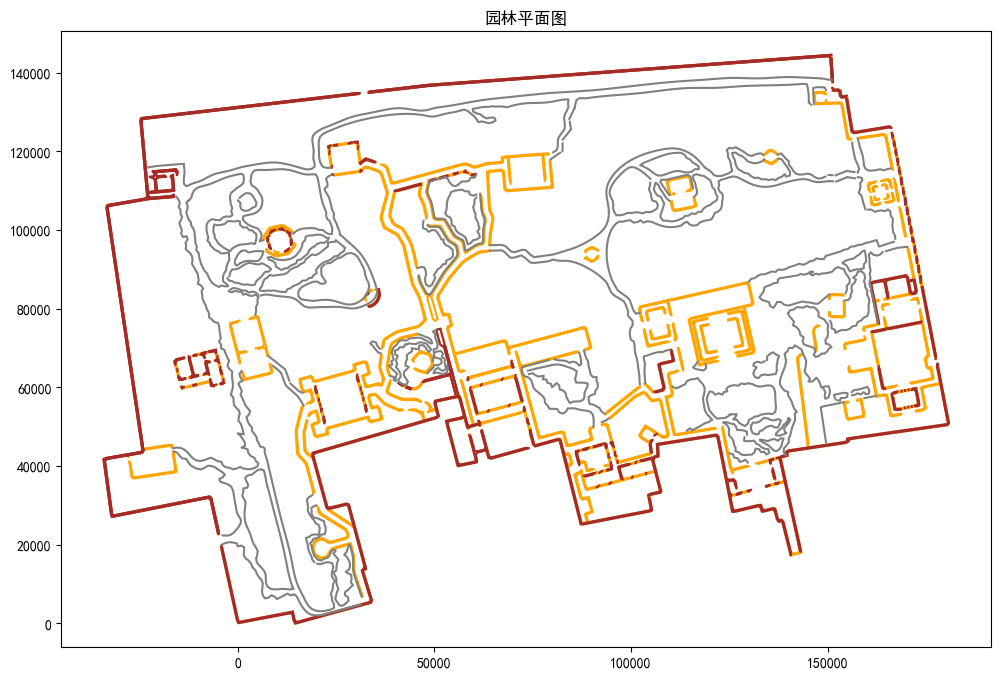

In [37]:
# 文件名：01_visualize_garden.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import ast

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# ========== 工具函数 ==========
def parse_point(s):
    """解析形如 {x,y,0} 的字符串为 (x, y)"""
    if isinstance(s, str):
        s = s.strip().replace("{", "").replace("}", "")
        vals = [float(v) for v in s.split(",")]
        return vals[0], vals[1]
    return None

def parse_group_data(df):
    """将类似 {0;i}, j.{x,y,0} 的分组数据转为列表"""
    groups = {}
    current_group = None
    for item in df.iloc[:,0]:
        if isinstance(item, str) and item.strip().startswith("{0;"):
            current_group = item
            groups[current_group] = []
        else:
            if isinstance(item, str) and "." in item:
                _, point_str = item.split(".", 1)
                groups[current_group].append(parse_point(point_str))
    return groups

# ========== 数据读取 ==========
file = "data.xlsx"
sheets = ["半开放建筑", "实体建筑", "道路"]

elements = {}
for sheet in sheets:  # 前5类
    df = pd.read_excel(file, sheet_name=sheet)
    groups = parse_group_data(df)
    elements[sheet] = groups

# ========== 可视化 ==========
plt.figure(figsize=(12, 8))

# 绘制其它要素
colors = {
    "半开放建筑": "orange",
    "实体建筑": "brown",
    "道路": "gray",
}
for name, groups in elements.items():
    for _, pts in groups.items():
        xs, ys = zip(*pts)
        plt.plot(xs, ys, color=colors[name], label=name)

plt.title("园林平面图")
plt.axis("equal")
# plt.legend()
plt.savefig("demo.png")
plt.show()
# save



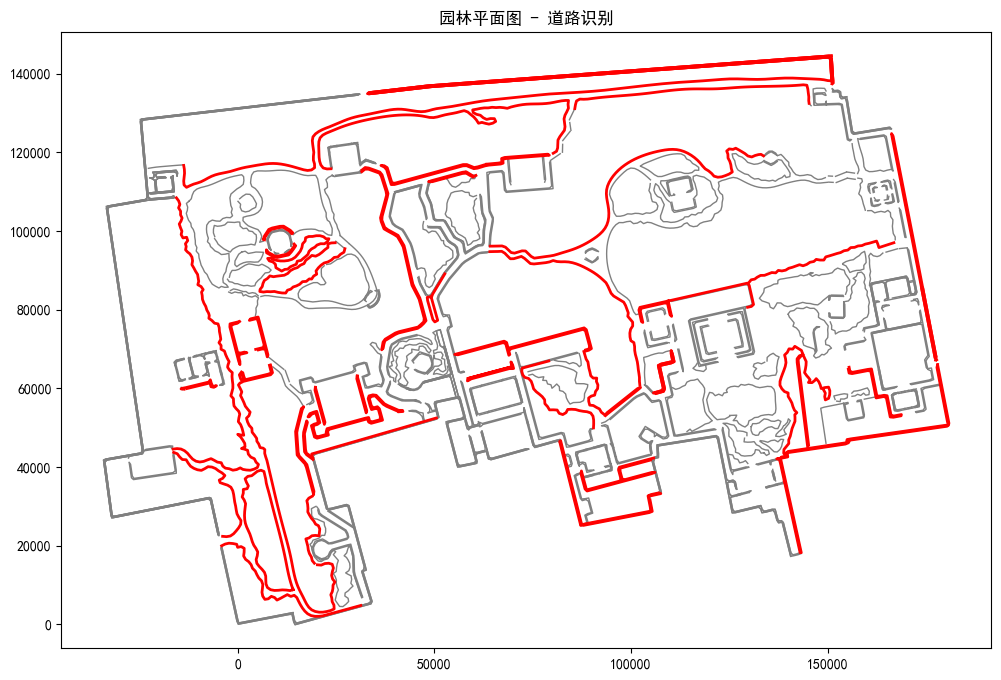

In [38]:
import numpy as np
import cv2

def is_road(points, ratio_thresh=3.0):
    """
    判断一个点集是否是道路
    - ratio_thresh: 长宽比阈值
    """
    pts = np.array(points, dtype=np.float32)
    if len(pts) < 5:
        return False

    # 最小外接矩形
    rect = cv2.minAreaRect(pts)
    (cx, cy), (w, h), angle = rect

    if w < 1 or h < 1:
        return False

    aspect_ratio = max(w, h) / (min(w, h) + 1e-5)

    # 判断条件：长宽比大 + 点数较多
    return aspect_ratio > ratio_thresh and len(pts) > 20

# ========== 识别道路 ==========
road_candidates = []
non_roads = []

for name, groups in elements.items():
    for gid, pts in groups.items():
        if is_road(pts):
            road_candidates.append(pts)
        else:
            non_roads.append(pts)

# ========== 可视化 ==========
plt.figure(figsize=(12, 8))

# 非道路
for pts in non_roads:
    xs, ys = zip(*pts)
    plt.plot(xs, ys, color="gray", linewidth=1)

# 识别为道路的部分
for pts in road_candidates:
    xs, ys = zip(*pts)
    plt.plot(xs, ys, color="red", linewidth=2)

plt.title("园林平面图 - 道路识别")
plt.axis("equal")
plt.show()


In [41]:
# road_from_edges.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize
import networkx as nx

# ---------- 你的解析函数（原样复用） ----------
def parse_point(s):
    if isinstance(s, str):
        s = s.strip().replace("{", "").replace("}", "")
        vals = [float(v) for v in s.split(",")]
        return vals[0], vals[1]
    return None

def parse_group_data(df):
    groups = {}
    current_group = None
    for item in df.iloc[:,0]:
        if isinstance(item, str) and item.strip().startswith("{0;"):
            current_group = item
            groups[current_group] = []
        else:
            if isinstance(item, str) and "." in item:
                _, point_str = item.split(".", 1)
                groups[current_group].append(parse_point(point_str))
    return groups

# ---------- 读取数据（使用你原来的 Excel 读取方式） ----------
file = "data.xlsx"
sheets = ["半开放建筑", "实体建筑", "道路"]  # 如果你的文件结构不同请修改
elements = {}
for sheet in sheets:
    df = pd.read_excel(file, sheet_name=sheet)
    groups = parse_group_data(df)
    elements[sheet] = groups

# ---------- 工具：把 elements 展平成点集合/保留分组 ----------
def flatten_points_from_elements(elements):
    # 返回两样：所有点的 np.array，以及是否存在分组信息（grouped）
    all_pts = []
    grouped = {}
    has_groups = False
    for name, groups in elements.items():
        if isinstance(groups, dict):
            has_groups = True
            for gid, pts in groups.items():
                if len(pts) > 0:
                    grouped[gid] = pts
                all_pts.extend(pts)
        else:
            # 直接点列表
            all_pts.extend(groups)
    return np.array(all_pts), grouped if has_groups else None

pts_all, grouped = flatten_points_from_elements(elements)
if pts_all.size == 0:
    raise RuntimeError("未读到任何点，请检查 data.xlsx 的解析。")

# ---------- 参数（可调） ----------
MAX_SIZE = 2000            # 栅格最大边长(px)，越大精度越高但耗时/内存越大
MARGIN_PX = 5             # 绘制时的像素边距
EDGE_THICKNESS_PX = 3      # 初始栅格化时边缘线粗细 (px)
CLOSING_KERNEL = 7         # 形态学闭合核大小 (px)
MIN_SKELETON_SEGMENT_LEN = 30  # 骨架段长度（像素）低于此值会被丢弃
SKELETON_WIDTH_PERCENTILE = 40 # 用于选取“窄”的骨架点，取骨架点距离的百分比阈值

# ---------- 栅格化（把散点/分组绘到二值图） ----------
xs = pts_all[:,0]; ys = pts_all[:,1]
minx, maxx = xs.min(), xs.max()
miny, maxy = ys.min(), ys.max()
W_world = maxx - minx
H_world = maxy - miny
scale = MAX_SIZE / max(W_world, H_world)  # px per world-unit
W = int(np.ceil(W_world * scale)) + 2 * MARGIN_PX
H = int(np.ceil(H_world * scale)) + 2 * MARGIN_PX

def world2px(pt):
    xw, yw = pt
    xpx = int(round((xw - minx) * scale)) + MARGIN_PX
    ypx = int(round((yw - miny) * scale)) + MARGIN_PX
    return xpx, ypx

# 创建空图像（单通道）
img = np.zeros((H, W), dtype=np.uint8)

if grouped is not None and len(grouped) > 0:
    # 若存在分组，按每组绘制折线（更连贯）
    for gid, pts in grouped.items():
        if len(pts) < 2:
            continue
        arr = np.array([world2px(p) for p in pts], dtype=np.int32)
        # cv2.polylines expects shape (n,1,2)
        cv2.polylines(img, [arr], isClosed=False, color=255, thickness=EDGE_THICKNESS_PX, lineType=cv2.LINE_AA)
else:
    # 没有分组：逐点画小圆，后面靠闭合连接
    for p in pts_all:
        xpx, ypx = world2px(p)
        cv2.circle(img, (xpx, ypx), radius=EDGE_THICKNESS_PX, color=255, thickness=-1)

# 形态学闭合，填补细小间隙
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (CLOSING_KERNEL, CLOSING_KERNEL))
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)

# ---------- 找轮廓并填充为“障碍物/非道路”掩码 ----------
contours, _ = cv2.findContours(img_closed, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
mask_objs = np.zeros_like(img_closed, dtype=np.uint8)
cv2.drawContours(mask_objs, contours, -1, color=255, thickness=cv2.FILLED)

# ---------- 可通行空间 = 掩码补集（注意去掉和图像边界相连的外部大空白） ----------
free_space = (mask_objs == 0).astype(np.uint8) * 255

# 找出与边界相连的连通区域（视为“外部”）并去掉
num_labels, labels = cv2.connectedComponents(free_space, connectivity=8)
border_labels = set()
# top/bottom/left/right 行列
border_labels.update(np.unique(labels[0, :]).tolist())
border_labels.update(np.unique(labels[-1, :]).tolist())
border_labels.update(np.unique(labels[:, 0]).tolist())
border_labels.update(np.unique(labels[:, -1]).tolist())

interior_free = np.zeros_like(free_space)
for lab in range(1, num_labels):  # label 0 也可能是外部，使用 border_labels 判断
    if lab in border_labels:
        continue
    interior_free[labels == lab] = 255

# ---------- 距离变换 & 骨架化 ----------
# distanceTransform 需要前景非零（这里 interior_free 的前景=255）
dist = cv2.distanceTransform((interior_free > 0).astype(np.uint8), distanceType=cv2.DIST_L2, maskSize=5)
skel = skeletonize((interior_free > 0))  # boolean array

# ---------- 在骨架上通过距离筛选“窄（可能是道路）”骨架点 ----------
skel_px_coords = np.column_stack(np.nonzero(skel))  # (row(y_px), col(x_px))
if skel_px_coords.shape[0] == 0:
    raise RuntimeError("没有检测到骨架，可能栅格化/闭合参数需要调大（使得边界连通）")

skel_dist_vals = dist[skel]
# 经验阈值：选取骨架点距离的某一百分位作为“窄”阈值（你可调整 SKELETON_WIDTH_PERCENTILE）
width_thresh = np.percentile(skel_dist_vals, SKELETON_WIDTH_PERCENTILE)
road_skel = np.zeros_like(skel, dtype=bool)
road_skel[skel] = (dist[skel] <= width_thresh)

# ---------- 以连通组件（骨架段）为单位，过滤过短段 ----------
road_skel_u8 = (road_skel.astype(np.uint8) * 255)
num_rlabels, rlabels, stats, centroids = cv2.connectedComponentsWithStats(road_skel_u8, connectivity=8)
road_final = np.zeros_like(road_skel)
for lab in range(1, num_rlabels):
    seg_area = stats[lab, cv2.CC_STAT_AREA]
    if seg_area >= MIN_SKELETON_SEGMENT_LEN:
        road_final[rlabels == lab] = True

# ---------- 将像素坐标映射回原始世界坐标（用于绘图或导出折线） ----------
def px2world(xpx, ypx):
    xw = (xpx - MARGIN_PX) / scale + minx
    yw = (ypx - MARGIN_PX) / scale + miny
    return xw, yw

road_pixels = np.column_stack(np.nonzero(road_final))  # (row, col) -> (y_px, x_px)
road_world_pts = [px2world(int(x), int(y)) for (y,x) in road_pixels]  # 注意顺序

# ---------- （可选）把骨架像素连成路径（polyline）方便后续使用 ----------
# 用 networkx 把骨架像素构成图，然后从端点走最长路径得到有序点序列
def skeleton_to_polylines(bin_skel):
    nodes = set(map(tuple, np.column_stack(np.nonzero(bin_skel))))  # (row, col)
    G = nx.Graph()
    for (r, c) in nodes:
        G.add_node((r, c))
    # 8-邻域连边
    neighs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    nodes_set = nodes
    for (r, c) in nodes:
        for dr, dc in neighs:
            nb = (r+dr, c+dc)
            if nb in nodes_set:
                G.add_edge((r, c), nb)
    polylines = []
    for comp in nx.connected_components(G):
        sub = G.subgraph(comp)
        # 找端点（度 != 2）
        deg1 = [n for n,d in sub.degree() if d == 1]
        if len(deg1) >= 1:
            # 从任一端点走到最远节点（approx longest path）
            start = deg1[0]
            lengths = nx.single_source_shortest_path_length(sub, start)
            far = max(lengths, key=lengths.get)
            path = nx.shortest_path(sub, start, far)
            # 转换为 world 坐标并收集
            poly_world = [px2world(c, r) for (r, c) in path]  # 注意 (r,c) -> (x_px,y_px) 顺序
            polylines.append(poly_world)
        else:
            # 没有端点（环），直接取所有点按任意顺序
            pts = list(sub.nodes())
            poly_world = [px2world(c, r) for (r,c) in pts]
            polylines.append(poly_world)
    return polylines

polylines = skeleton_to_polylines(road_final)

# ---------- 可视化：原始边缘、填充的障碍物、内部空白、检测出的道路中心线 ----------
plt.figure(figsize=(12,10))
# 原始边缘点/轮廓（灰）
for name, groups in elements.items():
    for _, gpts in groups.items():
        if len(gpts) > 1:
            xs, ys = zip(*gpts)
            plt.plot(xs, ys, color='0.6', linewidth=0.6)

# 绘制填充的障碍物轮廓（半透明）
# 将 mask_objs 转换为 world coords 显示（快速方法：用 imshow）
plt.imshow(mask_objs, cmap='gray', alpha=0.15,
           extent=[minx, maxx, miny, maxy], origin='lower')

# 绘制道路 polyline（红色）
for poly in polylines:
    pxs = [p[0] for p in poly]
    pys = [p[1] for p in poly]
    plt.plot(pxs, pys, color='red', linewidth=1.5)

plt.title("从边缘点提取的道路（红色为中心线）")
plt.axis("equal")
plt.gca().invert_yaxis()  # 若你的坐标系原本 y 方向朝上，请根据需要注释
plt.show()

# ---------- 输出：polylines 可保存为 GeoJSON / CSV / 自定义格式 ----------
# 例如保存为简单的 CSV：每一行为一个 polyline 的点序列 (poly_id, x, y)
out_rows = []
for i, poly in enumerate(polylines):
    for (x,y) in poly:
        out_rows.append((i, x, y))
out_df = pd.DataFrame(out_rows, columns=['poly_id','x','y'])
out_df.to_csv("detected_road_polylines.csv", index=False)
print("检测到 %d 条 polyline，已保存到 detected_road_polylines.csv" % len(polylines))


RuntimeError: 没有检测到骨架，可能栅格化/闭合参数需要调大（使得边界连通）